# **Deep NLP project - Recommendation Systems**

Python Notebook for the development and testing of the team project for the *Deep Natural Language Processing* course (a.a. 2022/2023) @ *Politecnico di Torino*.

The [corresponding GitHub repository](https://github.com/micolrosini/KRED-Reccomendation-System) of this project consists of the following contents:
- Implementation of the code
- Problem statement & related works
- Dataset description
- Report paper about the whole activity
- Link to this notebook for the quick execution of the code

This notebook contains the loading and preprocessing of the Adressa Norwegian News Dataset used for the implementation of the Data Enrichment with News Reading Time extension.

At the end of this notebook there are blocks for the execution of all the three models.

***Authors:*** \\
*@micolrosini - s302935@studenti.polito.it* \\
*@gaiasabbatini - s291532@studenti.polito.it* \\
*@matteogarbarino - s265386@studenti.polito.it*

## 1. Import libraries & install the needed packages

In [ ]:
# Import libraries & install packages
from google.colab import drive      # to mount a Drive containing the dataset
import os, sys, importlib           # to handle files and directories
from time import time               # to estimate performances
import tarfile                      # to unzip the dataset
import json                         # to read structured raw text
import pandas as pd                 # for dataset management
from sys import getsizeof           # to check size of a variable (use %whos to see loist of all variables)
import gc                           # garbage collector for memory management
import pickle                       # used to store pickled versions of the datasets
from tqdm import tqdm               # to show progress of operations
import glob                         # to use regular expressions & paths
import shutil                       # to easily copy files
from urllib.parse import urlparse   # to retrieve specified fields from url string
import ast                          # to convert the string representations to dictionaries
import requests                     # to contact wikidata server
import csv                          # to build kg for addressa news

In [ ]:
!pip install tensorboardX
!pip install -U sentence-transformers

## 2. Environment setup
- Clone the GitHub repository of the project to get the code
- Position the working directory in the appropriate folder
- Mount the Google Drive in order to access the dataset (contact the team to have access to it)
- Move the dataset in the appropriate folder to be accessed by the code

In [ ]:
t1 = time()

# Clone the GitHub repository
repo = "KRED-Reccomendation-System"
if os.path.isdir(repo):
  !rm -rf {repo}

!git clone https://github.com/micolrosini/KRED-Reccomendation-System.git

# Enter the correct directory (with main.py)
%cd 'KRED-Reccomendation-System'

# Mount Drive with Dataset
drive.mount('/content/drive')

# Move the dataset in the correct folder for the code to run
%cp -R /content/drive/MyDrive/KRED/KRED/data /content/KRED-Reccomendation-System
%cp -R /content/drive/MyDrive/AdressaProcessed /content/KRED-Reccomendation-System/data

t2 = time()
print(f"\n\nStage completed in {str(round((t2-t1)/60, 2))} minutes")

Cloning into 'KRED-Reccomendation-System'...
remote: Enumerating objects: 578, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 578 (delta 106), reused 160 (delta 91), pack-reused 401
Receiving objects: 100% (578/578), 7.95 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (334/334), done.
/content/KRED-Reccomendation-System
Mounted at /content/drive
cp: cannot open '/content/drive/MyDrive/AdressaProcessed/behavior-day1.gsheet' for reading: Operation not supported


Stage completed in 5.77 minutes


# **Extension 1: Adressa dataset - Norwegian news dataset - Data loading and preprocessing**

This experiment uses the Adressa (small: 1 week) dataset which is a Norwegian news dataset including also a field representing the time spent by a user on an article. This information can be exploited to better infer the actual interest the user had towards each article and therefore enrich the model.

**Requirements**:
In order to run this section it's necessary to execute before sections *1. Import libraries & install the needed packages* and *2. Environment setup* which imports the dataset from Google Drive (section *3. Execution* shoul be skipped)

## 1.1 Unzip dataset

*Remark: This section and section 1.2 (together with its sub-sections) can be skipped since the dataset has already been generated and store on a Google Drive clound. It is possible to run directly 1.3*

In [ ]:
t1 = time()

# UNZIP THE DATASET

# File structured as:
#   AdressaSMALL.tar.gz --> one_week.tar --> one_week (folder) --> 7 files, one for each day of the week

fname = "AdressaSMALL.tar.gz"               # dataset compressed file name
datapath = "./data/"                        # dataset location
tar = tarfile.open(datapath+fname, "r:gz")  # open the .tar.gz file
tar.extractall(path=datapath)               # extract one_week folder and place it in ./data
tar.close()                                 # close the file handle

t2 = time()
print(f"\n\nStage completed in {str(round(t2-t1, 2))} seconds")



Stage completed in 89.72 seconds


## Insights about the dataset attributes:

The dataset is mostly composed of 2 types of rows (namely "Long row" and "Short row") structured as json formatting (read in memory as dictionaries).

The documentation of the dataset offers a description of most of the present fields.

The Short Row is (almost always) a subset of Long Row.



| Attribute | Type | Description | Long row | Short row |
|:--------------|:-----------|:------------|:------------|:------------|
| eventId | int | The identifier used to differentiate distinct events from the same user | True | True |
| activeTime | int | The active time on a page in seconds, if known | True | True |
| os | string | Operating system that the user used when log in. | True | True
| referrerUrl | sting | The URL of the referrer page. | True | False
| deviceType | string | The type of the device. | True | True
| sessionStart | boolean | Indicates whether the event is considered as the first event in session | True | True |
| sessionStop | boolean | Indicates whether the event is considered as the last event in session | True | True |
| userId | string | The cross-site user identifier which can be used to differentiate devices/browsers, or identify different subscription users by the user id | True | True |
| category | sting | The category of the news article. | False | False |
| city | string | The city name inferred from the IP address. | True | True |
| country | string | The country code inferred from the user’s IP address. | True | True |
| region | string | The region code inferred from the IP address. | True |  True |
| time | int | The time of event, measured in Unix time. | True | True |
| canonicalUrl | sting | Canonical URL as calculated based on incoming events and the fetched page content. | True | False |
| documentId (present as "id") | string | The document id. This will be the same for different URLs | True | False |
| title | string | The title of the article. | True | False |
| keywords | list | The keywords of the article. | True | False |
| namedEntities | list | The named entities of the article, including their types, counts and weights. | False | False |
| author | string | The author of the article. | True | False |
| publishTime | string | The publish time of the article. | True | False |
| profile | Array of object | A set of items which are extracted or generated from the page content. Usually a string or keywords or Named Entities from the page | True | False |
| item\* | sting | Item extracted or generated from the page content. Usually a string or keyword extracted from the page. | True* | False |
| referrerHostClass | string | NOT PRESENT IN THE DOCUMENTATION | True | True |
| url | string | NOT PRESENT IN THE DOCUMENTATION | True | True |
| referrerSearchEngine | string | NOT PRESENT IN THE DOCUMENTATION | True | False |
| query | string | NOT PRESENT IN THE DOCUMENTATION | ? | ? |
| referrerSocialNetwork | ? | NOT PRESENT IN THE DOCUMENTATION | ? | ? |
| category1 | ? | NOT PRESENT IN THE DOCUMENTATION | ? | ? |
| referrerQuery | ? | NOT PRESENT IN THE DOCUMENTATION | ? | ? |

(*) Item is not a field of the rows, but is a subfield of profile in the long rows

### Conclusions
After a careful examination, the attributes to keep are:
- eventId --> primary key of the table
- time --> to get a ordering & needed by behaviours.tsv
- userId --> needed by behaviours.tsv
- url --> needed by both news.ts used as News ID
- profile --> needed by news.tsv to extract entities
- category1 --> needed by news.tsv to extract entities
- keywords --> needed by news.tsv to extract entities
- title --> needed by news.tsv to extract entities
- activeTime --> needed to recreate user behavior.tsv
- sessionStart --> needed to recreate user history (possibly removable)
- sessionStop --> needed to recreate user history (possibly removable)



## 1.2 Read dataset in a proper structure

The dataset is composed of 7 files, one for each day of a week. Files are in .txt extension in which rows are strings with json formatting.

The 7 daily files are too big (w.r.t. Colab 12GB of RAM) to be directly loaded and processed in RAM within a single operation.

The procedure is the following:

Block 1.2.1

1. Read one daily file at the time
2. For each daily file, process it in batches of X rows at the time
3. The file is initially read as a list of strings (rows), then exploit JSON formatting to transition to a list of dictionaries and eventually obtain a pandas dataframe
4. In the process at point 3. many other transformations are applied in order to properly clean the data and reorganize the dataframe schema
5. Each dataframe obtained at point 4. (of the given batch size X) is saved as a segment of the given day
6. When all the segments of a day have been processed they are again loaded in memory and reassembled as a single day to be finally stored as a single .csv file

Block 1.2.2

7. All the 7 full daily .csv files are read and merged into a single weekly file
8. The weekly file is saved as a .csv file
9. All the daily and weekly files are also copied to the mounted Google Drive for future use

In [ ]:
"""
Remark: pickle has been abandoned due to lack of RAM, CSV format is in use, but
        the old variable and path names including "pickle" remain for sake of simplicity
        (could be refactored)

"""

t_start = time()

days = [1,2,3,4,5,6,7]

for d in days:
  SELECTED_DAY = d                            # loop on all the days

  BATCH_SIZE = 350000                         # how many lines to process at the time

  if SELECTED_DAY not in range(1,8):          # check selection is in [1,2,3,4,5,6,7]
    exit(-1)

  VERBOSE = False                              # print some additional info

  SAVE_MODE = "csv"                           # use pickle only with more than 12 GB of ram
  if SAVE_MODE not in ['csv', 'pkl']:         # check selection is valid
    exit(-1)

  DELETE_FINAL_DATAFRAME = True               # clear final df (whole day)

  datapath = "./data/"                                        # just a reminder
  adressa_datapath = datapath + "one_week/"                   # build the path of the unzipped Adressa dataset
  pickled_dataset_path = datapath + "pickled_dataset/"        # build the path where the csv datasets will be stored
  segments_dataset_path = pickled_dataset_path + "segments/"  # build the path where the daily csv segments will be stored

  filenames = os.listdir(adressa_datapath)    # get the list of the 7 daily filenames
  inputFileName = filenames[SELECTED_DAY-1]

  # Complete list of dataset attributes:
  """
  | eventId | city | activeTime | url | referrerHostClass | region | time
  | userId | sessionStart | deviceType | sessionStop | country | os | referrerUrl
  | profile | category1 | canonicalUrl | publishtime | keywords | id | title
  | author | referrerSearchEngine | referrerSocialNetwork | referrerQuery | query |
  """
  # Keep a subset of attributes
  attributes = [
                'eventId',        # primary key of the table
                'time',           # to get a ordering & needed by behaviours.tsv
                'userId',         # needed by behaviours.tsv

                #'id',            # newsId, needed by both news.tsv & behaviours.tsv BUT DROPPED since it not complete (url will work also as newsId, i.e. primary key for news)
                'url',            # needed by both news.tsv and behaviour.tsv (AND read line above)
                'profile',        # needed by both news.tsv and behaviour.tsv
                'category1',      # needed by both news.tsv and behaviour.tsv
                'keywords',       # needed by both news.tsv and behaviour.tsv
                'title',          # needed by both news.tsv and behaviour.tsv

                'activeTime',     # needed to classify into positive and negative list + useful to extract user history
                'sessionStart',   # potentially needed to recreate user history (boolean columns are negligible in terms of space)
                'sessionStop',    # potentially needed to recreate user history (boolean columns are negligible in terms of space)
                ]


  # =================================== START ===================================

  print(f"Preprocessing file {SELECTED_DAY} of {len(filenames)}")


  # 1. Read single file from disk
  # 2. split in rows
  # 3. free memory
  # 4. remove empty rows

  t1 = time()

  dataset = list()

  with open(adressa_datapath + inputFileName) as daily_file:  # open the selected file

    print('\t- Reading file from disk')
    fileContents = daily_file.read()                          # load the file into a single big string

    print('\t- Transforming file into a list of rows')
    dataset = dataset + fileContents.split("\n")              # split the whole file into lines & save the obtained rows into a list

    del fileContents                                          # free the memory
    gc.collect()                                              # call the garbage collector to force variables deletion

    dataset = list(filter(lambda a: a != '', dataset))        # lambda expression to keep only non-empty rows

  t2 = time()
  print(f"\t  Stage completed in {str(round(t2-t1, 2))} seconds")

  # 5. Loop on batches
  # 6. Restrict dataset size
  # 7. Cast to list of dictionaries
  # 8. Cast to datadrame
  # 9. Project on attributes
  # 10. Reorder & rename columns
  # 11. Free memory

  t1 = time()

  rowsOfTheDay = len(dataset)                             # total rows of selected day
  segmentsProcessed = 0                                   # how many batches have already been processed so far

  while segmentsProcessed*BATCH_SIZE < rowsOfTheDay:      # as long as there are still rows to process
    startIndex = segmentsProcessed*BATCH_SIZE             # reposition start index
    stopIndex = startIndex + BATCH_SIZE                   # reposition end index
    if stopIndex > rowsOfTheDay:                          # fix end index out of boundaries of dataframe
      stopIndex = rowsOfTheDay

    print(f'\n- Processing batch {segmentsProcessed+1} with indices [{startIndex},{stopIndex}] (total rows: {rowsOfTheDay})')

    datasetSmall = dataset[startIndex:stopIndex]          # restrict the dataset size to a batch
    gc.collect()                                          # free memory (nothing to free at first iteration)

    # Exploit JSON formatting of rows to get a list of dictionaries
    print('\t- Transforming the json-formatted list of rows into a list of dictionaries')
    c = 0                                                 # counter to track progression
    JSONDataset = list()                                  # new dataset handle
    for r in datasetSmall:                                # loop over each single row (string with json formatting)
      JSONDataset.append(json.loads(r))                   # each json row is transformed to a dictionary
      c += 1                                              # count the row as read
      print(f"\r\t- Casting JSON strings to dictionaries progress: {str(round(c/(stopIndex-startIndex)*100, 2))}%",end='')
    print(f"\r\t- Casting JSON strings to dictionaries progress: {str(round(c/(stopIndex-startIndex)*100, 2))}%")
    del datasetSmall                                      # free memory asap
    gc.collect()                                          # call the garbage collector to force variables deletion

    print('\t- Transforming the list of dictionaries into a pandas dataframe')
    df = pd.DataFrame(JSONDataset)                        # cast list of dictionaries to Pandas DataFrame
    del JSONDataset                                       # free memory asap
    gc.collect()                                          # call the garbage collector to force variables deletion

    print('\t- Projecting on the needed dataframe attributes')
    dfSmall = df[attributes]                              # project onto the needed attributes only
    dfSmall = dfSmall.reindex(columns=attributes)         # rearrange columns order

    if "category1" in dfSmall.columns:                    # rename column "category"
      dfSmall.rename(columns = {'category1':'category'}, inplace = True)

    del df                                                # free memory asap
    gc.collect()                                          # call the garbage collector to force variables deletion

    t2 = time()
    print(f"\t  Stage completed in {str(round(t2-t1, 2))} seconds\n")



    # 12. Save csv version of the segment
    # 13. Go back to 5. until all file has been processed

    t1 = time()
    outputSegmentName = f"day{SELECTED_DAY}segment{segmentsProcessed+1}.csv" # e.g. day1segment1.csv
    outputPath = segments_dataset_path + outputSegmentName                   # e.g. ./data/pickled_dataset/segments/day1segment1.csv

    if not os.path.exists(segments_dataset_path):          # create ./data/pickled_dataset/segments/ if not exists
      os.makedirs(segments_dataset_path)

    print('\t- Saving the segment on disk')
    dfSmall.to_csv(outputPath, index = False)              # ./data/pickled_dataset/segments/day1segment1.csv
    del dfSmall                                            # free the memory asap
    gc.collect()                                           # call the garbage collector to force variables deletion

    t2 = time()
    print(f"\t  Stage completed in {str(round(t2-t1, 2))} seconds\n")


    segmentsProcessed += 1
    print()

  print(f"- All batches have been processed and saved\n")

  # 14. re-load all .csv segments
  # 15. concatenate dataframe segments into a single dataframe
  # 16. save final pickled versionn of the day

  t1 = time()

  print(f"Reassembling segments of day {SELECTED_DAY}:")

  print('- Reading all the .CSV segments to build final dataset')

  segmentNames = glob.glob(segments_dataset_path + '*.csv')         # read all segments full paths

  c = 0                                                             # track the progression
  segments = list()                                                 # list of segments df that are going to be read
  for segmentName in segmentNames:                                  # for each csv segment
    print(f"\r\t- Unpickling segments: {str(round(c/len(segmentNames)*100, 2))}%",end='')
    segments.append(pd.read_csv(segmentName, index_col=False))      # read the segment
    c += 1
  print(f"\r\t- Unpickling segments: {str(round(c/len(segmentNames)*100, 2))}%")
  gc.collect()                                                      # free some memory in case of memory leaks

  print(f"\t- Concatenating segments into a single dataframe")
  finalDf = pd.concat(segments, ignore_index=True)                  # build final dataset concatenating segments (whole day)
  print(f"\t- Freeing memory")
  segments.clear()                                                  # free memory asap
  del segments                                                      # free memory asap
  gc.collect()                                                      # free memory asap

  if VERBOSE:                                                       # additional info on screen
    print(f"Dataframe length: {len(finalDf)} rows")
    print(f"Dataframe size: {str(round(getsizeof(finalDf) /1024 /1024,2))} MB")
    print(finalDf.info())

  if SAVE_MODE == 'pkl':                                            # DEPRECATED
    outputFileName = f"day{SELECTED_DAY}.pkl"
    outputPath = pickled_dataset_path + outputFileName
    print(f'- Saving final dataset as: {outputPath}')
    finalDf.to_pickle(outputPath)

  elif SAVE_MODE == 'csv':                                          # TO BE USED
    outputFileName = f"day{SELECTED_DAY}.csv"
    outputPath = pickled_dataset_path + outputFileName               # e.g. /content/KRED-Reccomendation-System/data/pickled_dataset/day1.csv
    print(f'- Saving final dataset as: {outputPath}')
    finalDf.to_csv(outputPath, index = False)

  else:
    # Should not happen
    print(f'- Failed to save final dataframe')

  print(f'- Saved successfully')

  if DELETE_FINAL_DATAFRAME:                                        # delete whole day df if not needed immediately
    del finalDf                                                     # free memory asap

  gc.collect()                                                      # free memory asap

  print(f'- Removing segments')
  if os.path.isdir(segments_dataset_path):                          # segments folder must be removed
    !rm -rf {segments_dataset_path}                                 #  to avoid interactions over different runs

  t2 = time()
  print(f"  Stage completed in {str(round(t2-t1, 2))} seconds\n")


t_end = time()
print(f"\n\nStage completed in {str(round(t_end-t_start, 2))} seconds")

Preprocessing file 1 of 7
	- Reading file from disk
	- Transforming file into a list of rows
	  Stage completed in 11.45 seconds

- Processing batch 1 with indices [0,350000] (total rows: 1513739)
	- Transforming the json-formatted list of rows into a list of dictionaries
	- Casting JSON strings to dictionaries progress: 100.0%
	- Transforming the list of dictionaries into a pandas dataframe
	- Projecting on the needed dataframe attributes
	  Stage completed in 138.78 seconds

	- Saving the segment on disk
	  Stage completed in 14.2 seconds



- Processing batch 2 with indices [350000,700000] (total rows: 1513739)
	- Transforming the json-formatted list of rows into a list of dictionaries
	- Casting JSON strings to dictionaries progress: 100.0%
	- Transforming the list of dictionaries into a pandas dataframe
	- Projecting on the needed dataframe attributes
	  Stage completed in 139.51 seconds

	- Saving the segment on disk
	  Stage completed in 12.67 seconds



- Processing batch 3 wit

1.2.2 Build final dataset:
- load all 7 daily files
- build weekly dataset
- store weekly dataset in the mounted Drive

In [ ]:
t1 = time()

DELETE = True                                               # cleanup at the end

dailyFileNames = glob.glob(pickled_dataset_path + '*.csv')  # get list of daily files paths

dayilyDfs = list()                                          # read all daily files into a list
progress = 0
for name in dailyFileNames:
  print(name)
  dayilyDfs.append(pd.read_csv(name, index_col=False))
  print(f"Dataframe length: {len(dayilyDfs[progress])} rows")
  print(f"Dataframe size: {str(round(getsizeof(dayilyDfs[progress]) /1024 /1024,2))} MB\n")
  progress += 1

weeklyDf = pd.concat(dayilyDfs, ignore_index=True)          # concatenate all daily files into a weekly file
print(f"Dataframe length: {len(weeklyDf)} rows")
print(f"Dataframe size: {str(round(getsizeof(weeklyDf) /1024 /1024,2))} MB\n")
print(weeklyDf.info())


if DELETE:                                                   # cleanup
  dayilyDfs.clear()
  del(dayilyDfs)
  gc.collect()


outputFileName = "week.csv"                         # Save weekly df on disk
outputPath = pickled_dataset_path + outputFileName  # e.g. /content/KRED-Reccomendation-System/data/pickled_dataset/week.csv
print(f'- Saving final dataset as: {outputPath}')
weeklyDf.to_csv(outputPath, index = False)          # WARNING: files is 9+GB --> takes a lot of time

# save on drive --> i.e. copy files in drive folder
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/week.csv", "/content/drive/MyDrive/AdressaProcessed/week.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day1.csv", "/content/drive/MyDrive/AdressaProcessed/day1.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day2.csv", "/content/drive/MyDrive/AdressaProcessed/day2.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day3.csv", "/content/drive/MyDrive/AdressaProcessed/day3.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day4.csv", "/content/drive/MyDrive/AdressaProcessed/day4.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day5.csv", "/content/drive/MyDrive/AdressaProcessed/day5.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day6.csv", "/content/drive/MyDrive/AdressaProcessed/day6.csv")
shutil.copy("/content/KRED-Reccomendation-System/data/pickled_dataset/day7.csv", "/content/drive/MyDrive/AdressaProcessed/day7.csv")


t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

./data/pickled_dataset/day3.csv
Dataframe length: 1087223 rows
Dataframe size: 1334.42 MB

./data/pickled_dataset/day1.csv
Dataframe length: 1513739 rows
Dataframe size: 1630.48 MB

./data/pickled_dataset/day6.csv
Dataframe length: 1648346 rows
Dataframe size: 1935.27 MB

./data/pickled_dataset/day5.csv
Dataframe length: 1327429 rows
Dataframe size: 1674.37 MB

./data/pickled_dataset/day2.csv
Dataframe length: 1613128 rows
Dataframe size: 1880.59 MB

./data/pickled_dataset/day4.csv
Dataframe length: 1496417 rows
Dataframe size: 2182.39 MB

./data/pickled_dataset/day7.csv
Dataframe length: 1356987 rows
Dataframe size: 1237.12 MB

Dataframe length: 10043269 rows
Dataframe size: 11874.65 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043269 entries, 0 to 10043268
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   eventId       int64  
 1   time          int64  
 2   userId        object 
 3   url           object 
 4   profile       object

##1.3 Read preprocess Adressa dataset

*Remark: This block doesn't necessarily require the execution of blocks 1.1, 1.2 and their sub-blocks since the preprocessed datasets have already been stored on Google Drive*

1.3.1 Load the desired input

Can load one of the seven daily files or the week file (latter to be used for final model)

In [ ]:
t1 = time()

SELECTED_INPUT = 'week.csv'         # select the needed input file
VERBOSE = True                      # to print additional information

if SELECTED_INPUT not in ['week.csv', 'day1.csv', 'day2.csv', 'day3csv', 'day4.csv', 'day5.csv', 'day6.csv', 'day7.csv']:
  exit(-1)

inputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'  # use this copy in local disk, never modify version in Drive folder
inputPath = inputFolder + SELECTED_INPUT                                    # e.g. /content/KRED-Reccomendation-System/data/AdressaProcessed/day1.csv

inputDf = pd.read_csv(inputPath, index_col=False)
print(f'Loaded file: {SELECTED_INPUT}')
if VERBOSE:
  print(f"Dataframe length: {len(inputDf)} rows")
  print(f"Dataframe size: {str(round(getsizeof(inputDf) /1024 /1024,2))} MB\n")
  print(inputDf.info())
  # print(inputDf[0:10])

t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

1.3.2 Work towards behaviours.tsv format
- compute mean & standard deviation of reading time (for each user)
- classify each entry as element to be put into positive or negative list
- build dataset structured as behaviours.tsv

In [ ]:
# Build the columns of mean active time for each user
# --> obtain: userDf
t1 = time()

VERBOSE = True

userTimeDf = inputDf.groupby(['userId'])["activeTime"].aggregate(['min', 'max', 'median', 'mean', 'std'])     # for each userId obtain mean & std dev of activeTime (+ other aggregations useful for data exploration)
userTimeDf.rename(columns = {'mean':'userMeanActiveTime', 'std':'userStdDevActiveTime'}, inplace = True)      # rename useful columns
userTimeDf = userTimeDf[['userMeanActiveTime', 'userStdDevActiveTime']]                                       # select columns for the join (userId isn't a column, but the index of the table)

userDf = inputDf.join(userTimeDf, on='userId', validate='m:1')                                                # left-join over userId, validate n:1 multiplicity of key attributes

if VERBOSE:
  print(userTimeDf.info())
  print(userDf.info())

del userTimeDf                                                                  # free memory
gc.collect()                                                                    # free memory

t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

In [ ]:
"""
1. Filter out useless attributes
2. Filter out users whose activeTime is always NaN --> not informative (do not allow computation of userMeanActiveTime)
3. Set all remaining NaN activeTimes to -1 (this tell us that the user immediately closed the page, in less than a second)
4. Classify each row as element for a Positive List or Negative List
6. Build positive & negative lists and drop users with empty lists
7. Build a new datadrame with same schema of behaviors.tsv and save it
"""

t1 = time()

VERBOSE = True
DOUBLE_BOUNDARY = True

# 1. FILTER OUT USELESS ATTRIBUTES
#   Select only the columns needed by behaviours.tsv
#   ---> obtain: behaviorDf1

print("\n1. Projecting on columns subset")
attributes = ['userId', 'time', 'url', 'activeTime', 'userMeanActiveTime', 'userStdDevActiveTime']
behaviorDf1 = userDf[attributes]
if VERBOSE:
  print("\n\n=============== STEP 1 ===============\n")
  print(behaviorDf1.info())


# 2. FILTER OUT NON-INFORMATIVE USERS
#   Keep only a subset of rows where the users have at least one activeTime not NaN (i.e. discard users for which can't compute mean active time)
#   ---> obtain: behaviorDf2

print("\n2. Removing users without at least 1 activeTime!=NaN")
behaviorDf2 = behaviorDf1[behaviorDf1['userMeanActiveTime'].notna()]   # filter out users whose activeTime = NaN for all rows
behaviorDf2 = behaviorDf2[behaviorDf2['userStdDevActiveTime'].notna()]   # filter out users whose activeTime = NaN for all rows
if VERBOSE:
  print("\n\n=============== STEP 2 ===============\n")
  print(f'Dropped {len(behaviorDf1)-len(behaviorDf2)} rows of the initial {len(behaviorDf1)}')
  print(behaviorDf2.info())


# 3. FILL "MISSING" DATA
#   Whenever activeTime = NaN it means that activeTime < 1second therefore it can still be treated as a low active time and flagged with a -1 to make it numerical
#   ---> obtain: behaviorsDf3
#   should this approach have negative impact on the performances they can still be dropped instead (since are flagged with a unique value)
print("\n3. Filling remaining NaN activeTime with -1")
behaviorDf3 = behaviorDf2
behaviorDf3['activeTime'] = behaviorDf3['activeTime'].fillna(-1)
# behaviorDf3 = behaviorDf3[behaviorDf3['activeTime'].notna()]           # use this row instead to drop rows with -1
if VERBOSE:
  print("\n\n=============== STEP 3 ===============\n")
  filled = len(behaviorDf3[behaviorDf3['activeTime']==-1])
  print(f'Filled {filled} rows of the {len(behaviorDf3)} total rows')
  print(behaviorDf3.info())


# 4. CLASSIFY EACH ROW (i.e. each clicked news by each user) AS POSITIVE/NEGATIVE LIST ELEMENT
#   If activeTime <  meanUserActiveTime - 1 * userStdDevActiveTime --> Negative List
#   If activeTime >= meanUserActiveTime - 1 * userStdDevActiveTime --> Negative List
#   alternatively use a range: positive if inside range [mean - stdDev ; mean + stdDev] & negative otherwise
#   ---> obtain: behaviorDf4

print("\n4. Classifying clicks")
behaviorDf4 = behaviorDf3

if DOUBLE_BOUNDARY:
  behaviorDf4['condition1'] = (behaviorDf4['activeTime'] >= (behaviorDf4['userMeanActiveTime'] - behaviorDf4['userStdDevActiveTime']))
  behaviorDf4['condition2'] = (behaviorDf4['activeTime'] <= (behaviorDf4['userMeanActiveTime'] + behaviorDf4['userStdDevActiveTime']))
  behaviorDf4['positiveElement'] = (behaviorDf4['condition1'] == behaviorDf4['condition2'])
else:
  behaviorDf4['positiveElement'] = (behaviorDf4['activeTime'] >= (behaviorDf4['userMeanActiveTime'] - behaviorDf4['userStdDevActiveTime']))
attrib = ['userId', 'time', 'url', 'positiveElement']
behaviorDf4 = behaviorDf4[attrib]



#   (DEPRECATED approach below)
#   Add two columns with satisfaction indices as satisfactionIndexMean   = activeTime / userMeanActiveTime
#                                                satisfactionIndexMedian = activeTime / userMedianActiveTime
#   Normalize these indices in range [0,1] to make them comparable with each other --> not necessary since it's just used for ordering
# behaviorDf4['satisfactionIndexMean']   = userDf['activeTime'] / userDf['userMeanActiveTime']      # compute a statistic based on the mean active time of each user
# Indices normalization
# minSatisfactionIndexMean = behaviorDf4['satisfactionIndexMean'].min()
# maxSatisfactionIndexMean = behaviorDf4['satisfactionIndexMean'].max()
# behaviorDf4['satisfactionIndexMeanNormalized'] = (behaviorDf4['satisfactionIndexMean'] - minSatisfactionIndexMean) / (maxSatisfactionIndexMean - minSatisfactionIndexMean)


if VERBOSE:
  print("\n\n=============== STEP 4 ===============\n")
  posCount = len( behaviorDf4[behaviorDf4['positiveElement'] == True] )
  negCount = len( behaviorDf4[behaviorDf4['positiveElement'] == False] )
  print(f'{posCount} rows classified as positive clicks ({str(round(posCount/len(behaviorDf4)*100, 2))}%)')
  print(f'{negCount} rows classified as negative clicks ({str(round(negCount/len(behaviorDf4)*100, 2))}%)')
  print(behaviorDf4.info())


t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

In [ ]:
t1 = time()


updateFreq = 500
GC_FREQ = 1000
VERBOSE = True


behaviorDf5 = pd.DataFrame(columns=['userId', 'timestamp', 'positiveList', 'negativeList'])         # final dataframe initialization

uniqueUsersDf = behaviorDf4['userId'].unique()                                                      # list of unique userIds
amountOfUsers = len(uniqueUsersDf)                                                                  # count of unique userIds
totRowsProcessed = 0                             # count how many rows from behaviorDf4 have been processed
inputRowsKept = 0                                # count how many rows from behaviorDf4 have been kept and condensed into pos/neg lists
totRows = len(behaviorDf4)                       # tot rows to be processed from behaviorDf4
progress = 0                                     # track progress of behaviorDf5 creation (row by row) --> i.e. how many users have been processed and kept
usersDropped = 0                                 # count how many users dropped due to empty lists


print(f'(printing updates every: {updateFreq} users - tot users: {amountOfUsers})\n')

for usr in uniqueUsersDf:                                                                           # for each user
  if (progress+usersDropped) % updateFreq == 0:                                                     # print every X users processed (to not impact on performances)
    print(f"\rProcessing: {str(round((progress+usersDropped)/amountOfUsers*100, 2))}% - Elapsed time: {str(round(time()-t1, 2))}s",end='')
  userClicksDf = behaviorDf4[behaviorDf4['userId'] == usr]                                          # get the user's clicks
  tstamp = (userClicksDf.sort_values(by=['time'], ascending=True).head(1)).iloc[0]['time']          # get the earlier timestamp of that user's clicks

  positiveClicks = (userClicksDf[userClicksDf['positiveElement'] == True])['url'].unique().tolist() # get positive list
  negativeClicks = (userClicksDf[userClicksDf['positiveElement'] == False])['url'].unique().tolist()# get negative list
  commonElements = set(positiveClicks).intersection(negativeClicks)                                 # check if the lists have elements in common
  if len(commonElements) > 0:                                                                       # if they have, remove them from the longer list
    for elem in commonElements:
      if len(negativeClicks) >= len(positiveClicks):
        negativeClicks.remove(elem)
      else:
        positiveClicks.remove(elem)
  commonElements = set(positiveClicks).intersection(negativeClicks)                                 # double check if some common elements still exist (redundandt)
  if len(commonElements) > 0:
    print(f"\nWARNING: overlapping positive & negative lists at row {progress}")
    print(commonElements)

  totRowsProcessed += len(userClicksDf)                                                             # keep track of how many rows have been read from input

  if len(positiveClicks) == 0 or len(negativeClicks) == 0:                                          # if at least a list is empty --> discard user
    usersDropped += 1
  else:                                                                                             # else add new row and increase counter progress
    behaviorDf5.loc[progress] = [usr, tstamp, positiveClicks, negativeClicks]
    inputRowsKept += len(positiveClicks)                                                            # keep count of how many clicks have been kept
    inputRowsKept += len(negativeClicks)
    progress += 1

  del positiveClicks                                                                                # delete all temporary dfs
  del negativeClicks
  del userClicksDf
  del commonElements
  if (progress+usersDropped) % GC_FREQ == 0:
    gc.collect()                                                                                    # free memory every X users

print(f"\rProcessing: {str(round((progress+usersDropped)/amountOfUsers*100, 2))}%")

print(f'Tot input rows processed: {totRowsProcessed} wrt to total input rows: {len(behaviorDf4)}')
print(f'Dropped input rows: {totRowsProcessed-inputRowsKept} (due to empty lists)')
print(f'Users dropped: {usersDropped} wrt to processed users: {usersDropped+progress}(due to empty lists)')



# SAVE ON DISK & ON MOUNTED DRIVE:

DELETE = False                                                # cleanup dataframe at the end?

outputFileName = SELECTED_INPUT                               # usually "day1.csv" or "week.csv"
outputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'
outputPath = outputFolder + 'behavior-' + outputFileName      # '/content/KRED-Reccomendation-System/data/AdressaProcessed/behavior-day1.csv'
print(f'\nSaving final dataset as: {outputPath}')
behaviorDf5.to_csv(outputPath, index = True)

if DELETE:                                                    # cleanup
  print('\n Deleting final dataframe')
  behaviorDf5.clear()
  del(behaviorDf5)
  gc.collect()

# save on drive --> i.e. copy files in drive folder
mountedDriveOutputPath = "/content/drive/MyDrive/AdressaProcessed/"+'behavior-' + outputFileName
print(f'Copying final dataset into mounted Drive at: {mountedDriveOutputPath}')
shutil.copy(outputPath, mountedDriveOutputPath)

if VERBOSE:
  print(behaviorDf5)

t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

1.3.2.1  Build final weekly dataset *behavior-week.tsv*

- Read the 7 daily behavior files: behavior-day1.csv, behavior-day2.csv, ...
- Reshape the columns properly (there was an error in the formatting of history and positive/negative lists)
- Concatenate the 7 files into one single file

In [ ]:
# LOAD THE DAILY FULLY PROCESSED DATAFRAMES
t1 = time()

SELECTED_INPUTS = ['behavior-day1.csv', 'behavior-day2.csv', 'behavior-day3.csv', 'behavior-day4.csv', 'behavior-day5.csv', 'behavior-day6.csv', 'behavior-day7.csv']
VERBOSE = False                                                                 # to print additional information

inputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'      # source folder

dfsToReshape = list()                                                           # list where input DFs will be stored
counter = 0
for i in SELECTED_INPUTS:
 inputPath = inputFolder + i                                                    # e.g. /content/KRED-Reccomendation-System/data/AdressaProcessed/behavior-day1.csv
 dfsToReshape.append(pd.read_csv(inputPath, index_col=False))                   # read all daily behaviors and add them to the list
 print(f'Loaded file: {SELECTED_INPUTS[counter]}')
 if VERBOSE:
    print(f"Dataframe length: {len(dfsToReshape[counter])} rows")
    print(f"Dataframe size: {str(round(getsizeof(dfsToReshape[counter]) /1024 /1024,2))} MB\n")
    print(dfsToReshape[counter].info())
 counter += 1

print(f"The {len(dfsToReshape)} input dataframes have been loaded correctly")
if VERBOSE:
 print(dfsToReshape)

t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

Loaded file: behavior-day1.csv
Loaded file: behavior-day2.csv
Loaded file: behavior-day3.csv
Loaded file: behavior-day4.csv
Loaded file: behavior-day5.csv
Loaded file: behavior-day6.csv
Loaded file: behavior-day7.csv
The 7 input dataframes have been loaded correctly

Stage completed in 9.06 seconds



In [ ]:
# RESHAPE THE COLUMNS PROPERLY
t1 = time()

reshapedDfs = list()                                                            # list to store the final version of the daily behavior dataframes
counter = 0

for df in dfsToReshape:                                                         # for each daily behavior DF

  newDf = df.copy(deep=True)                                                    # make a true copy, not just a link
  newDf['newPositiveList'] = ''                                                 # add two new columns
  newDf['newPosNegList'] = ''
  for index, row in newDf.iterrows():                                                                                           # process it row by row
    newPosListCol = row['positiveList'].replace("'", "").replace("[", "").replace("]", "").replace(",", "")                     # create a userHistory column from the previous positiveList (it's an approximation)
    oldPosList = row['positiveList'].replace("'", "").replace("[", "").replace("]", "-1").replace(",", "").replace(" ", "-1 ")  # append a -1 to all the elements of the positive list (as if they were indeed clicked in KRED)
    oldNegList = row['negativeList'].replace("'", "").replace("[", "").replace("]", "-0").replace(",", "").replace(" ", "-0 ")  # append a -0 to all the elements of the negative list (as if they were NOT clicked in KRED)
    newPosNegListCol = oldPosList + ' ' + oldNegList                                                                            # build one final list of positive and negative elements as required by KRED in input
    newDf.at[index, 'newPositiveList'] = newPosListCol                                                                          # store obtained results in the new columns
    newDf.at[index, 'newPosNegList'] = newPosNegListCol

  columnsToKeep = ['userId', 'timestamp', 'newPositiveList', 'newPosNegList']                                                   # project on the needed columns only
  newDf = newDf[columnsToKeep]
  newDf = newDf.rename(columns={'newPositiveList': 'userHistory', 'newPosNegList': 'positiveAndNegativeLists'})                 # give meaningful names

  counter += 1
  print(f"\n\nCompleted processing of day {counter} behaviors")
  print(newDf.info())


  reshapedDfs.append(newDf)                                                                                                     # store the final version of the daily behavior DF


t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")



Completed processing of day 1 behaviors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101726 entries, 0 to 101725
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   userId                    101726 non-null  object
 1   timestamp                 101726 non-null  int64 
 2   userHistory               101726 non-null  object
 3   positiveAndNegativeLists  101726 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB
None


Completed processing of day 2 behaviors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111067 entries, 0 to 111066
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   userId                    111067 non-null  object
 1   timestamp                 111067 non-null  int64 
 2   userHistory               111067 non-null  object
 3   positiveAndNegativeLists  11106

In [ ]:
t1 = time()
# CONCATENATE DAYS AND SAVE
behaviorWeek = pd.concat(reshapedDfs)                                                                       # build weekly behavior DF by concatenation
behaviorWeek['index'] = behaviorWeek.index + 1                                                              # build the index column (needed to match KRED input schema)
behaviorWeek = behaviorWeek[['index', 'userId', 'timestamp', 'userHistory', 'positiveAndNegativeLists']]

outputFileName = "behavior-week.tsv"                                                                        # Save weekly df on disk
outputPath = "/content/KRED-Reccomendation-System/data/AdressaProcessed/" + outputFileName
print(f'Saving final dataset as: {outputPath}')
if not os.path.exists("/content/KRED-Reccomendation-System/data/AdressaProcessed/"):                        # create directory to store data if doesnt exists
  os.makedirs("/content/KRED-Reccomendation-System/data/AdressaProcessed/")

behaviorWeek.to_csv(outputPath, sep="\t", index = False, header = False)                                    # save as .tsv (tab separated values)

# save on drive --> i.e. copy files in drive folder
print(f'Saving backup on mounted Drive: /content/drive/MyDrive/AdressaProcessed/behavior-week.tsv')         # save backup on Google Drive
shutil.copy("/content/KRED-Reccomendation-System/data/AdressaProcessed/behavior-week.tsv", "/content/drive/MyDrive/AdressaProcessed/behavior-week.tsv")

t2 = time()
print(f"\nStage completed in {str(round(t2-t1, 2))} seconds\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703985 entries, 0 to 98530
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   index                     703985 non-null  int64 
 1   userId                    703985 non-null  object
 2   timestamp                 703985 non-null  int64 
 3   userHistory               703985 non-null  object
 4   positiveAndNegativeLists  703985 non-null  object
dtypes: int64(2), object(3)
memory usage: 32.2+ MB
None
       index                                       userId   timestamp  \
0          1            cx:hwwz74npvfpbeb6t:3r8a34vl30pzx  1483258706   
1          2   cx:35qzmnop24aabdict6ce06jeu:3oh8amzr1ymie  1483235637   
2          3   cx:g5w8dqvwmphi3312fz77s1cnu:1lphshweqrtpp  1483268001   
3          4   cx:2wdlftbi226e93j6ubrrr9ywlk:xi3bokxgktuc  1483231519   
4          5   cx:1tsqelygc061ozuetu9i0pkny:2ko62cresl3dx  1483278506   
...      ...

In [ ]:
# CHECKING FINAL RESULT
inputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'
inputPath = inputFolder + 'behavior-week.tsv'
df = pd.read_csv(inputPath, header = None, sep='\t')
print(df)
print(df.info())

            0                                            1           2  \
0           1            cx:hwwz74npvfpbeb6t:3r8a34vl30pzx  1483258706   
1           2   cx:35qzmnop24aabdict6ce06jeu:3oh8amzr1ymie  1483235637   
2           3   cx:g5w8dqvwmphi3312fz77s1cnu:1lphshweqrtpp  1483268001   
3           4   cx:2wdlftbi226e93j6ubrrr9ywlk:xi3bokxgktuc  1483231519   
4           5   cx:1tsqelygc061ozuetu9i0pkny:2ko62cresl3dx  1483278506   
...       ...                                          ...         ...   
703980  98527  cx:2k8lgs1vgl9xz1a6kr7rjx7kjy:2n79xb1k1lwjf  1483743465   
703981  98528   cx:3v8gihnk10reauqe9k0y0txe9:2ka2lazfrqc0q  1483743471   
703982  98529  cx:18c0bo93pwom21dssre7v527ba:2h8mqy93ylyei  1483743473   
703983  98530             cx:hvl65l18rxqbg0p9:999mgd3b8ile  1483743504   
703984  98531             cx:i6vg2muycor2g7tb:wqowc9878gun  1483743516   

                                                        3  \
0       http://adressa.no/nyheter/trondheim/2016/1

In [ ]:
# GET STATISTICS
uniqueUsers = df[1].unique()
print(len(uniqueUsers))

inputPath = '/content/KRED-Reccomendation-System/data/AdressaProcessed/week.csv'
inputDf = pd.read_csv(inputPath, index_col=False)
print(inputDf.info())

uniqueURLs = inputDf['url'].unique()
print(len(uniqueURLs))
print(inputDf.shape[0])

281521
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10043269 entries, 0 to 10043268
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   eventId       int64  
 1   time          int64  
 2   userId        object 
 3   url           object 
 4   profile       object 
 5   category      object 
 6   keywords      object 
 7   title         object 
 8   activeTime    float64
 9   sessionStart  bool   
 10  sessionStop   bool   
dtypes: bool(2), float64(1), int64(2), object(6)
memory usage: 708.8+ MB
None


In [ ]:
# DEPRECATED BLOCK OF CODE
# Schema:[['index', 'userId', 'timestamp', 'userHistory', 'positiveAndNegativeLists']]
# EXPERIMENT: REMOVING THE URL 'http://adressa.no' AND SAVING AS "behavior-week-v2.tsv"

newDf = pd.DataFrame(columns=['index','userId','timestamp','userHistory','positiveAndNegativeLists'])

for i, row in df.iterrows():
  DISCARD_ROW_FLAG = False

  userHistory = row[3]
  userBehavior = row[4]

  userHistory = userHistory.split(' ')
  userBehavior = userBehavior.split(' ')

  newUserHistory = []
  newUserBehavior = []

  for el in userHistory:
    if el != 'http://adressa.no':
      newUserHistory.append(el)

  countPos = 0
  countNeg = 0
  for el in userBehavior:
    if el != 'http://adressa.no-1' and el != 'http://adressa.no-0':
      newUserBehavior.append(el)
      label = (el.split('-'))[-1]
      if label == '1':
        countPos += 1
      elif label == '0':
        countNeg += 1
      else:
        print("ERROR: unidentified label")

  if len(newUserHistory) == 0 or countPos == 0 or countNeg == 0:
    DISCARD_ROW_FLAG = True

  finalUserHistory = ''
  finalUserBehavior = ''

  for el in newUserHistory:
    finalUserHistory = finalUserHistory + el + ' '

  for el in newUserBehavior:
    finalUserBehavior = finalUserBehavior + el + ' '

  finalUserHistory = finalUserHistory[:-1]
  finalUserBehavior = finalUserBehavior[:-1]


  if not DISCARD_ROW_FLAG:
    newDf.loc[len(newDf)] = [row[0], row[1], row[2], finalUserHistory, finalUserBehavior]

  if i % 1000 == 0:
    print(f'Progress: {i}/{df.shape[0]}')

newDf['index'] = newDf.index + 1

print(df.info())
print(newDf.info())

outputFileName = "behavior-week-v2.tsv"                                                                        # Save weekly df on disk
outputPath = "/content/KRED-Reccomendation-System/data/AdressaProcessed/" + outputFileName
print(f'Saving final dataset as: {outputPath}')
if not os.path.exists("/content/KRED-Reccomendation-System/data/AdressaProcessed/"):                        # create directory to store data if doesnt exists
  os.makedirs("/content/KRED-Reccomendation-System/data/AdressaProcessed/")

newDf.to_csv(outputPath, sep="\t", index = False, header = False)                                    # save as .tsv (tab separated values)

# save on drive --> i.e. copy files in drive folder
print(f'Saving backup on mounted Drive: /content/drive/MyDrive/AdressaProcessed/behavior-week-v2.tsv')         # save backup on Google Drive
shutil.copy("/content/KRED-Reccomendation-System/data/AdressaProcessed/behavior-week-v2.tsv", "/content/drive/MyDrive/AdressaProcessed/behavior-week-v2.tsv")

Progress: 0/703985
Progress: 1000/703985
Progress: 2000/703985
Progress: 3000/703985
Progress: 4000/703985
Progress: 5000/703985
Progress: 6000/703985
Progress: 7000/703985
Progress: 8000/703985
Progress: 9000/703985
Progress: 10000/703985
Progress: 11000/703985
Progress: 12000/703985
Progress: 13000/703985
Progress: 14000/703985
Progress: 15000/703985
Progress: 16000/703985
Progress: 17000/703985
Progress: 18000/703985
Progress: 19000/703985
Progress: 20000/703985
Progress: 21000/703985
Progress: 22000/703985
Progress: 23000/703985
Progress: 24000/703985
Progress: 25000/703985
Progress: 26000/703985
Progress: 27000/703985
Progress: 28000/703985
Progress: 29000/703985
Progress: 30000/703985
Progress: 31000/703985
Progress: 32000/703985
Progress: 33000/703985
Progress: 34000/703985
Progress: 35000/703985
Progress: 36000/703985
Progress: 37000/703985
Progress: 38000/703985
Progress: 39000/703985
Progress: 40000/703985
Progress: 41000/703985
Progress: 42000/703985
Progress: 43000/703985
P

# 1.3.3 Work towards news.tsv format
*Now that all news have been extracted one can skip this section and go to 1.3.4 to directly build knowledge graph *

In [ ]:
# Fill category and add subcategory column starting from url
def cat_subcat_from_url(url):
  """Given an URL as input, return title, category, subcategory as strings"""
  #Parse the URL
  parsed_url = urlparse(url)

  #Get path from parsed URL
  path = parsed_url.path

  #Split path into segments divided by '/'
  segments = path.split('/')

  #Extract desired parts

  #Category
  category = segments[1]

  #Subcategory
  if (len(segments) > 2):
    subcategory = segments[2]
  else:
    subcategory = None

  return category, subcategory

# get wikiid for each entity
# Function to retrieve Wikidata ID for an item
def get_wikidata_id(item):
    # Query Wikidata for the item using its label
    url = f'https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&search={item}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'search' in data:
            search_results = data['search']
            if search_results:
                # Get the first result (highest score)
                result = search_results[0]
                if 'id' in result:
                    return result['id']
    return None

# Transform 'profile' column
def df_get_wikidata_id(df):
  df['profile'] = df['profile'].apply(lambda x: [{'Label': item['item'], 'Type': item['group'], 'Confidence': item['weight'], 'WikidataId': get_wikidata_id(item['item'])} for item in x])
  return None

In [ ]:
# Observe number of missing values per attribute
print(f'The Datasets contains the following null values in the fields:\n{inputDf.isnull().sum()}')
#create dataset with only profile rows
df_profile = inputDf.dropna(subset=['profile'])
df_profile = df_profile.drop(['eventId', 'time', 'userId', 'activeTime', 'sessionStart', 'sessionStop'], axis=1)
print(f'\nNew df containing only rows with profile:\n {df_profile.isnull().sum()}')

t1 = time()
print('\nStarting to extract info from news URL and update rows...\n')

# Apply the function to the 'url' column and store the results in new columns
df_profile[['new_category', 'subcategory']] = df_profile['url'].apply(lambda url: pd.Series(cat_subcat_from_url(url)))

# Fill NaN values in the 'category' column using values from 'title' column
df_profile['category'].fillna(df_profile['new_category'], inplace=True)
df_profile = df_profile.drop(['category'], axis=1)
df_profile.rename(columns={'new_category': 'category'}, inplace=True)
df_profile.head()# Apply the function to the 'url' column and store the results in new columns
df_profile[['new_category', 'subcategory']] = df_profile['url'].apply(lambda url: pd.Series(cat_subcat_from_url(url)))

# Fill NaN values in the 'category' column using values from 'title' column
df_profile['category'].fillna(df_profile['new_category'], inplace=True)
df_profile = df_profile.drop(['category'], axis=1)
df_profile.rename(columns={'new_category': 'category'}, inplace=True)
df_profile.head()

# Remove duplicate rows
df_profile = df_profile.drop_duplicates(subset='url', keep='first')

t2 = time()
print(f"\nExtraction completed in {str(round(t2-t1, 2))} seconds\n")

# Print the resulting DataFrame with unique URLs
print(f'Resulting DataFrame with unique URLs has {len(df_profile)} rows \n')

t1 = time()
print('Starting to modify profile column towards new.tsv format...\n')


# Update the 'profile' column to contain the desired list of dictionaries, remove items with 'group' : ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']
#df_profile['profile'].to_dict()
try:
  df_profile['profile'] = df_profile['profile'].apply(ast.literal_eval)
except:
  print('profile column is already a python dictionary')
df_profile['profile'] = df_profile['profile'].apply(lambda x: [{'item': item['item'], **group} for item in x for group in item['groups']if item['item'] != '0' and group['group'] not in ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']])# Update the 'profile' column to contain the desired list of dictionaries, remove items with 'group' : ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']
#df_profile['profile'].to_dict()
try:
  df_profile['profile'] = df_profile['profile'].apply(ast.literal_eval)
  df_profile['profile'] = df_profile['profile'].apply(lambda x: [{'item': item['item'], **group} for item in x for group in item['groups']if item['item'] != '0' and group['group'] not in ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']])
except:
  print('profile column is already a python dictionary')
  # Update the 'profile' column to contain the desired list of dictionaries
  df_profile['profile'] = df_profile['profile'].apply(lambda x: [item for item in x if item['item'] != '0' and item['group'] not in ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']])
#df_profile['profile'] = df_profile['profile'].apply(lambda x: [{'item': item['item'], **group} for item in x for group in item['groups']if item['item'] != '0' and group['group'] not in ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']])

# Update the 'profile' column to contain the desired list of dictionaries
#df_profile['profile'] = df_profile['profile'].apply(lambda x: [item for item in x if item['item'] != '0' and item['group'] not in ['site', 'author', 'language', 'pageclass', 'adressa-access', 'adressa-tag']])

t2 = time()
print(f"\nOperation completed in {str(round(t2-t1, 2))} seconds\n")
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
t1 = time()
print('Adding WikidataID to news entities and remove etities not found on wikidata server...\n')
# Load the datasets
inputPath_news = inputFolder + SELECTED_INPUT
inputPath_ent =  inputFolder + 'entities-week.csv'
df_entities = pd.read_csv(inputPath_ent, index_col=False)
df_news = df_profile

# Create a dictionary to map wikiid values to entities
wikiid_dict = dict(zip(df_entities['item'], df_entities['wikiid']))

# Iterate over each row in the news dataset
for index, row in tqdm(df_news.iterrows()):
    profile = row['profile']
    updated_profile = []

    # Iterate over each dictionary in the 'profile' list
    for dictionary in profile:
        label = dictionary['item']
        group = dictionary['group']
        weight = dictionary['weight']
        count = dictionary['count']

        # Get the corresponding wikiid from the entities dataset
        wikiid = wikiid_dict.get(label)

        # Only add dictionaries with a valid wikiid
        if wikiid is not None:
            updated_dict = {
                'Label': label,
                'Type': group,
                'WikidataId': wikiid,
                'Confidence': weight,
                'OccurrenceOffsets': count,
                'SurfaceForms': [label.split(',')[0]]  # Modify?
            }
            updated_profile.append(updated_dict)

    # Update the 'profile' column with the updated profile list
    df_news.at[index, 'profile'] = updated_profile

t2 = time()
print(f"\nOperation completed in {str(round(t2-t1, 2))} seconds\n")

# Update the output path construction
outputFileName = SELECTED_INPUT.split('.')[0] + '_updated_news_dataset.tsv'
outputPath = outputFolder + outputFileName

print(f'\nSaving final dataset as: {outputPath}')

# Save the updated dataset as TSV
df_news.to_csv(outputPath, sep='\t', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Copy the file to the mounted drive folder
mountedDriveOutputPath = "/content/drive/MyDrive/AdressaProcessed/" + outputFileName
print(f'Copying final dataset into mounted Drive at: {mountedDriveOutputPath}')
shutil.copy(outputPath, mountedDriveOutputPath)

The Datasets contains the following null values in the fields:
eventId               0
time                  0
userId                0
url                   0
profile         6941278
category        7756434
keywords        7391531
title           6941278
activeTime      4780659
sessionStart          0
sessionStop           0
dtype: int64

New df containing only rows with profile:
 url              0
profile          0
category    815156
keywords    450253
title            0
dtype: int64

Starting to extract info from news URL and update rows...


Extraction completed in 989.98 seconds

Resulting DataFrame with unique URLs has 20429 rows 

Starting to modify profile column towards new.tsv format...

profile column is already a python dictionary

Operation completed in 16.99 seconds

Adding WikidataID to news entities and remove etities not found on wikidata server...



20429it [00:03, 6361.19it/s]



Operation completed in 3.36 seconds


Saving final dataset as: /content/KRED-Reccomendation-System/data/AdressaProcessed/week_updated_news_dataset.tsv
Copying final dataset into mounted Drive at: /content/drive/MyDrive/AdressaProcessed/week_updated_news_dataset.tsv


'/content/drive/MyDrive/AdressaProcessed/week_updated_news_dataset.tsv'

In [ ]:
news_path = '/content/drive/MyDrive/AdressaProcessed/news_day2.csv'
if SELECTED_INPUT != 'day2.csv':
  # First dataset
  df1 = pd.read_csv(news_path, index_col=False, header= None)
  df1.columns = ['url']

  # Second dataset
  df2 = df_profile

  # Merge the datasets based on 'url' column
  merged = df2.merge(df1, on='url', how='left')

  # Filter the rows where the other columns are not null (not present in the first dataset)
  filtered_df2 = merged[merged['url'].isnull() | merged['profile'].isnull() | merged['keywords'].isnull() | merged['title'].isnull() | merged['category'].isnull() | merged['subcategory'].isnull()]
  df_profile = filtered_df2
  # Print the filtered dataframe
  print(f'new dataset length {len(filtered_df2)} and it has {filtered_df2.isnull().sum()} empty rows \n')

new dataset length 1094 and it has url               0
profile           0
keywords       1092
title             0
category          0
subcategory       2
dtype: int64 empty rows 



In [ ]:
# Initialize an empty list
item_list = []

# Iterate over each row in the column
for row in tqdm(df_profile['profile']):
    # Iterate over each dictionary in the row
    for dictionary in row:
        # Extract the 'item' value from the dictionary
        item = dictionary['item']

        # Check if the 'item' value is already in the list
        if item not in item_list:
            # Append the 'item' value to the list
            item_list.append(item)

# Print the resulting list length
print(f'\n The resulting list of entities contains {len(item_list)} items')

100%|██████████| 1094/1094 [00:02<00:00, 506.80it/s]


 The resulting list of entities contains 12406 items


In [ ]:
# Create a list of dictionaries with 'item' and 'wikiid'
list_ent = []

# Iterate over the item_list
for el in tqdm(item_list):
    # Create a new dictionary for each item
    dict_ent = {}
    dict_ent['item'] = el
    dict_ent['wikiid'] = get_wikidata_id(el)

    # Append the dictionary to the list
    list_ent.append(dict_ent)

100%|██████████| 12406/12406 [26:35<00:00,  7.78it/s]


In [ ]:
# save current day entities and wiki_id into a csv
#DELETE = False                                                # cleanup dataframe at the end?

outputFileName = SELECTED_INPUT                               # usually "day1.csv" or "week.csv"
outputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'
outputPath = outputFolder + 'entities-' + outputFileName      # '/content/KRED-Reccomendation-System/data/AdressaProcessed/entities-day1.csv'
print(f'\nSaving final dataset as: {outputPath}')
df_entites = pd.DataFrame.from_dict(list_ent)
df_entites.to_csv(outputPath, index = True)


# save on drive --> i.e. copy files in drive folder
mountedDriveOutputPath = "/content/drive/MyDrive/AdressaProcessed/"+'entities-' + outputFileName
print(f'Copying final dataset into mounted Drive at: {mountedDriveOutputPath}')
shutil.copy(outputPath, mountedDriveOutputPath)


Saving final dataset as: /content/KRED-Reccomendation-System/data/AdressaProcessed/entities-day7.csv
Copying final dataset into mounted Drive at: /content/drive/MyDrive/AdressaProcessed/entities-day7.csv


'/content/drive/MyDrive/AdressaProcessed/entities-day7.csv'

In [ ]:
if SELECTED_INPUT != 'day2.csv':
  # Append the DataFrame rows to the existing file
  outputPath = 'news_day2.csv'
  df_profile['url'].to_csv(outputPath, header=False, index=False, mode='a')
else:
  outputPath = 'news_'+ outputFileName +'.txt'
  file = open('news_'+ outputFileName +'.txt','w')
  for item in df_profile['url']:
    file.write(item+"\n")
  file.close()

# save on drive --> i.e. copy files in drive folder
mountedDriveOutputPath = "/content/drive/MyDrive/AdressaProcessed/"+'news_' + outputPath
print(f'Copying final dataset into mounted Drive at: {mountedDriveOutputPath}')
shutil.copy(outputPath, mountedDriveOutputPath)

Copying final dataset into mounted Drive at: /content/drive/MyDrive/AdressaProcessed/news_news_day2.csv


'/content/drive/MyDrive/AdressaProcessed/news_news_day2.csv'

## 1.3.4 Build KG


In [ ]:
def get_entity_info(entity_id):
    response = requests.get(f"https://www.wikidata.org/wiki/Special:EntityData/{entity_id}.json")
    if response.status_code == 200:
        entity_data = response.json()
        entities = entity_data.get('entities', {})
        if entity_id in entities:
            return entities[entity_id]
    return None


In [ ]:
input_path = "/content/drive/MyDrive/AdressaProcessed/"
# Concatenate datasets vertically
# First dataset
df1 = pd.read_csv(input_path + 'entities-day1.csv', index_col=False) # entities extracted from day 1
df1.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column
df2 = pd.read_csv(input_path + 'entities-day2.csv', index_col=False) # entities extracted from day 2
df2.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column
df3 = pd.read_csv(input_path + 'entities-day3.csv', index_col=False) # entities extracted from day 3
df3.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column
df4 = pd.read_csv(input_path + 'entities-day4.csv', index_col=False) # entities extracted from day 4
df4.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column
df5 = pd.read_csv(input_path + 'entities-day5.csv', index_col=False) # entities extracted from day 5
df5.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column
df6 = pd.read_csv(input_path + 'entities-day6.csv', index_col=False) # entities extracted from day 6
df6.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column
df7 = pd.read_csv(input_path + 'entities-day7.csv', index_col=False) # entities extracted from day 7
df7.dropna(subset=['wikiid'], inplace=True) # Drop rows with NaN values in the 'wikiid' column

# The ignore_index=True option resets the index of the appended dataset
appended_df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

# Remove duplicates from the DataFrame
appended_df = appended_df.drop_duplicates()
# Drop unamed column
appended_df = appended_df.drop('Unnamed: 0', axis=1)
# Print the appended dataset length
print(f'we have collected {len(appended_df)} entities')

outputFileName = 'week.csv'                            # usually "day1.csv" or "week.csv"
outputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'
outputPath = outputFolder + 'entities-' + outputFileName      # '/content/KRED-Reccomendation-System/data/AdressaProcessed/entities-day1.csv'
print(f'\nSaving final dataset as: {outputPath}')
appended_df.to_csv(outputPath, index = True)

# save on drive --> i.e. copy files in drive folder
mountedDriveOutputPath = "/content/drive/MyDrive/AdressaProcessed/"+'entities-' + outputFileName
print(f'Copying final dataset into mounted Drive at: {mountedDriveOutputPath}')
shutil.copy(outputPath, mountedDriveOutputPath)

we have collected 71394 entities

Saving final dataset as: /content/KRED-Reccomendation-System/data/AdressaProcessed/entities-week.csv
Copying final dataset into mounted Drive at: /content/drive/MyDrive/AdressaProcessed/entities-week.csv


'/content/drive/MyDrive/AdressaProcessed/entities-week.csv'

In [ ]:
def get_entity_info(entity_id):
    response = requests.get(f"https://www.wikidata.org/wiki/Special:EntityData/{entity_id}.json")
    if response.status_code == 200:
        entity_data = response.json()
        entities = entity_data.get('entities', {})
        if entity_id in entities:
            return entities[entity_id]
    return None


entity_ids = appended_df['wikiid']  # Entity IDs to build to kg
entities = {}
for entity_id in tqdm(entity_ids):
    entity_info = get_entity_info(entity_id)
    if entity_info:
        entities[entity_id] = entity_info

knowledge_graph = {}
for entity_id, entity_info in tqdm(entities.items()):
    knowledge_graph[entity_id] = {}
    if 'claims' in entity_info:
        claims = entity_info['claims']
        for prop, values in claims.items():
            property_values = []
            for value in values:
                if 'mainsnak' in value and 'datavalue' in value['mainsnak']:
                    data_value = value['mainsnak']['datavalue']
                    if data_value.get('type') == 'wikibase-entityid' and 'value' in data_value:
                        property_values.append(data_value['value']['id'])
            if property_values:
                knowledge_graph[entity_id][prop] = property_values

100%|██████████| 33681/33681 [00:02<00:00, 11567.58it/s]


In [ ]:
# Specify the output file name
output_file = 'knowledge_graph_addressa.tsv'
outputFolder = '/content/KRED-Reccomendation-System/data/AdressaProcessed/'
outputPath = output_file     # '/content/KRED-Reccomendation-System/data/AdressaProcessed/knowledge_graph_addressa.tsv'

# Write the knowledge graph to the .tsv file
with open(output_file, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')

    # Iterate over each entity and its properties in the knowledge graph
    for entity_id, properties in knowledge_graph.items():
        for prop, values in properties.items():
            # Write each relationship to a row in the .tsv file
            for value in values:
                writer.writerow([entity_id, prop, value])

print(f"Knowledge graph saved to '{outputFolder + output_file}'.")

# save on drive --> i.e. copy files in drive folder
mountedDriveOutputPath = "/content/drive/MyDrive/AdressaProcessed/"+ output_file
print(f'\n Copying final KG into mounted Drive at: {mountedDriveOutputPath}')
shutil.copy(outputPath, mountedDriveOutputPath)

Knowledge graph saved to 'knowledge_graph_addressa.tsv'.

 Copying final KG into mounted Drive at: /content/drive/MyDrive/AdressaProcessed/knowledge_graph_addressa.tsv


'/content/drive/MyDrive/AdressaProcessed/knowledge_graph_addressa.tsv'

# **Execution section:**
The following subsections to run the extensions and base model follow:
- Extension 1: Domain Adaptation to Movies Recommendation
- Extension 2: Data Enrichment with News Reading Time
- KRED Base Model on News Articles user2item recommendation

# **Extension 1: MindReader dataset for Domain Adaptation to Movies Recommendation**

In [ ]:
!nvidia-smi

Mon Jul 17 18:11:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cp "/content/drive/MyDrive/KRED/KRED/data/mind_reader_dataset/movies.pkl" "/content/KRED-Reccomendation-System/data/mind_reader_dataset/"

In [ ]:
t1 = time()
!python movies_rec_training.py
t2 = time()
print(f"\n\nStage completed in {str(round((t2-t1)/60, 2))} minutes")

Starting grid search for hyper-parameters optimization:


Testing the following configuration:
Number of epochs: 5
Batch size: 64
Learning rate: 1e-05


model training
all loss: tensor(205.7510, device='cuda:0', grad_fn=<AddBackward0>)
auc socre: 0.5787044620398795
Saving checkpoint: out/saved/models/KRED/0717_181114/checkpoint-model-epoch1.pth ...
all loss: tensor(201.8669, device='cuda:0', grad_fn=<AddBackward0>)
auc socre: 0.6041049475175382
Saving checkpoint: out/saved/models/KRED/0717_181114/checkpoint-model-epoch2.pth ...
all loss: tensor(195.8505, device='cuda:0', grad_fn=<AddBackward0>)
auc socre: 0.6457361759641226
Saving checkpoint: out/saved/models/KRED/0717_181114/checkpoint-model-epoch3.pth ...
all loss: tensor(189.8437, device='cuda:0', grad_fn=<AddBackward0>)
auc socre: 0.6707151435866288
Saving checkpoint: out/saved/models/KRED/0717_181114/checkpoint-model-epoch4.pth ...
all loss: tensor(186.4525, device='cuda:0', grad_fn=<AddBackward0>)
auc socre: 0.6814602760608335
Sa

In [ ]:
r1 = dict({'epochs': 5, 'batch_size': 64, 'learning_rate': 1e-05, 'auc_score': 0.6814602760608335, 'ndcg_score': 0.6410457898283654})
r2 = dict({'epochs': 5, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.695238178124312, 'ndcg_score': 0.9148568823583791})
r3 = dict({'epochs': 5, 'batch_size': 64, 'learning_rate': 5e-05, 'auc_score': 0.7048497456112947, 'ndcg_score': 0.7670273914429264})
r4 = dict({'epochs': 5, 'batch_size': 128, 'learning_rate': 1e-05, 'auc_score': 0.6571823622405994, 'ndcg_score': 0.4922818839877926})
r5 = dict({'epochs': 5, 'batch_size': 128, 'learning_rate': 2e-05, 'auc_score': 0.6895128519659585, 'ndcg_score': 0.571614567891588})
r6 = dict({'epochs': 5, 'batch_size': 128, 'learning_rate': 5e-05, 'auc_score': 0.6857091522218894, 'ndcg_score': 0.8669479898642711})
r7 = dict({'epochs': 7, 'batch_size': 64, 'learning_rate': 1e-05, 'auc_score': 0.6927520213221738, 'ndcg_score': 0.7818048722226502})
r8 = dict({'epochs': 7, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.6930816532624385, 'ndcg_score': 0.6754160255557639})
r9 = dict({'epochs': 7, 'batch_size': 64, 'learning_rate': 5e-05, 'auc_score': 0.6971757754038292, 'ndcg_score': 0.8165901947515999})
r10 = dict({'epochs': 7, 'batch_size': 128, 'learning_rate': 1e-05, 'auc_score': 0.6823132668420102, 'ndcg_score': 0.7702043899253147})
r11 = dict({'epochs': 7, 'batch_size': 128, 'learning_rate': 2e-05, 'auc_score': 0.6955314862707052, 'ndcg_score': 0.47682620352203725})
r12 = dict({'epochs': 7, 'batch_size': 128, 'learning_rate': 5e-05, 'auc_score': 0.7027064203794349, 'ndcg_score': 0.7624164915943119})
r13 = dict({'epochs': 10, 'batch_size': 64, 'learning_rate': 1e-05, 'auc_score': 0.6903038983874311, 'ndcg_score': 0.9148568823583791})
r14 = dict({'epochs': 10, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.7002926134290242, 'ndcg_score': 0.715550648768261})
r15 = dict({'epochs': 10, 'batch_size': 64, 'learning_rate': 5e-05, 'auc_score': 0.701366753361287, 'ndcg_score': 0.7573821447149967})
r16 = dict({'epochs': 10, 'batch_size': 128, 'learning_rate': 1e-05, 'auc_score': 0.6911652792168351, 'ndcg_score': 0.4105719800676482})
r17 = dict({'epochs': 10, 'batch_size': 128, 'learning_rate': 2e-05, 'auc_score': 0.692617116370198, 'ndcg_score': 0.9148568823583791})
r18 = dict({'epochs': 10, 'batch_size': 128, 'learning_rate': 5e-05, 'auc_score': 0.7058701022043764, 'ndcg_score': 0.6678262889110272})

grid_search_results = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18]
for r in grid_search_results:
        print(r)


{'epochs': 5, 'batch_size': 64, 'learning_rate': 1e-05, 'auc_score': 0.6814602760608335, 'ndcg_score': 0.6410457898283654}
{'epochs': 5, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.695238178124312, 'ndcg_score': 0.9148568823583791}
{'epochs': 5, 'batch_size': 64, 'learning_rate': 5e-05, 'auc_score': 0.7048497456112947, 'ndcg_score': 0.7670273914429264}
{'epochs': 5, 'batch_size': 128, 'learning_rate': 1e-05, 'auc_score': 0.6571823622405994, 'ndcg_score': 0.4922818839877926}
{'epochs': 5, 'batch_size': 128, 'learning_rate': 2e-05, 'auc_score': 0.6895128519659585, 'ndcg_score': 0.571614567891588}
{'epochs': 5, 'batch_size': 128, 'learning_rate': 5e-05, 'auc_score': 0.6857091522218894, 'ndcg_score': 0.8669479898642711}
{'epochs': 7, 'batch_size': 64, 'learning_rate': 1e-05, 'auc_score': 0.6927520213221738, 'ndcg_score': 0.7818048722226502}
{'epochs': 7, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.6930816532624385, 'ndcg_score': 0.6754160255557639}
{'epochs': 7, '

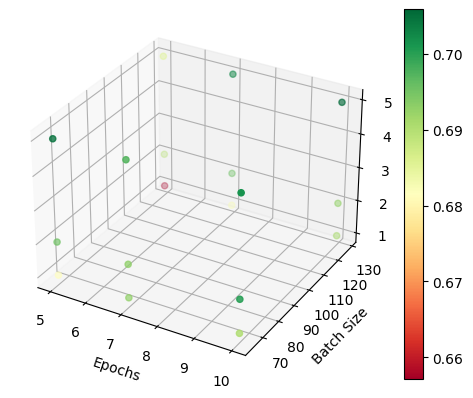

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

epochs = []
batch_sizes = []
learning_rates = []
auc_scores = []
ndcg_scores = []

for r in grid_search_results:
  epochs.append(r['epochs'])
  batch_sizes.append(r['batch_size'])
  learning_rates.append(r['learning_rate'])
  auc_scores.append(r['auc_score'])
  ndcg_scores.append(r['ndcg_score'])

img1 = ax.scatter(epochs, batch_sizes, learning_rates, c=auc_scores, cmap=cm.RdYlGn)  # AUC Scores
#img2 = ax.scatter(epochs, batch_sizes, learning_rates, c=ndcg_scores, cmap=cm.Greys) # NDCG Scores
ax.set_xlabel("Epochs")
ax.set_ylabel("Batch Size")
ax.set_zlabel("Learning Rate")
fig.colorbar(img1)    # AUC Scores
#fig.colorbar(img2)   # NDCG Scores
plt.show()

# **Extension 2: Data Enrichment with News Reading Time from Adressa Dataset**

In [ ]:
!nvidia-smi

Fri Jul 14 21:34:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
t1 = time()
!python addressa_rec_training.py
t2 = time()
print(f"\n\nStage completed in {str(round((t2-t1)/60, 2))} minutes")

In [5]:
r1 = dict({'epochs': 5, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.5822759366832905, 'ndcg_score': 0.2769434091627734})
r2 = dict({'epochs': 5, 'batch_size': 64, 'learning_rate': 5e-05, 'auc_score': 0.5989811269627553, 'ndcg_score': 0.3102832648624573})
r3 = dict({'epochs': 5, 'batch_size': 128, 'learning_rate': 2e-05, 'auc_score': 0.6297948602760267, 'ndcg_score': 0.3901456373457898})
r4 = dict({'epochs': 5, 'batch_size': 128, 'learning_rate': 5e-05, 'auc_score': 0.6108369298598261, 'ndcg_score': 0.3357573907295277})


grid_search_results = [r1, r2, r3, r4]
for r in grid_search_results:
        print(r)


{'epochs': 5, 'batch_size': 64, 'learning_rate': 2e-05, 'auc_score': 0.5822759366832905, 'ndcg_score': 0.2769434091627734}
{'epochs': 5, 'batch_size': 64, 'learning_rate': 5e-05, 'auc_score': 0.5989811269627553, 'ndcg_score': 0.3102832648624573}
{'epochs': 5, 'batch_size': 128, 'learning_rate': 2e-05, 'auc_score': 0.6297948602760267, 'ndcg_score': 0.3901456373457898}
{'epochs': 5, 'batch_size': 128, 'learning_rate': 5e-05, 'auc_score': 0.6108369298598261, 'ndcg_score': 0.3357573907295277}


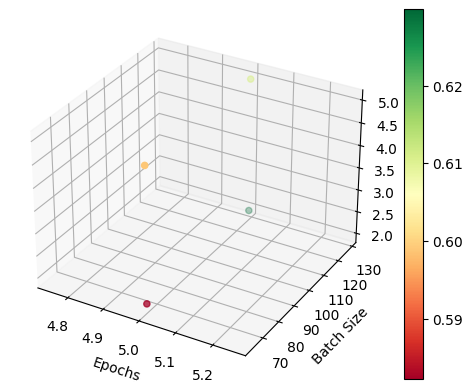

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

epochs = []
batch_sizes = []
learning_rates = []
auc_scores = []
ndcg_scores = []

for r in grid_search_results:
  epochs.append(r['epochs'])
  batch_sizes.append(r['batch_size'])
  learning_rates.append(r['learning_rate'])
  auc_scores.append(r['auc_score'])
  ndcg_scores.append(r['ndcg_score'])

img1 = ax.scatter(epochs, batch_sizes, learning_rates, c=auc_scores, cmap=cm.RdYlGn)  # AUC Scores
#img2 = ax.scatter(epochs, batch_sizes, learning_rates, c=ndcg_scores, cmap=cm.Greys) # NDCG Scores
ax.set_xlabel("Epochs")
ax.set_ylabel("Batch Size")
ax.set_zlabel("Learning Rate")
fig.colorbar(img1)    # AUC Scores
#fig.colorbar(img2)   # NDCG Scores
plt.show()

# **3. KRED Base Model execution for user2item news articles recommendation:**

In [ ]:
t1 = time()
!python News_rec_training.py
t2 = time()
print(f"\n\nStage completed in {str(round((t2-t1)/60, 2))} minutes")

Data loaded, ready for training
Starting grid search for hyper-parameters optimization:


Testing the following configuration:
Number of epochs: 5
Batch size: 64
Learning rate: 2e-05


model training
all loss: tensor(1705.3806, device='cuda:0', grad_fn=<AddBackward0>)
auc score: 0.569792098915223
